In [7]:
# import external libraries
# and self-defined color map

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import concatenate, merge, Dense, LSTM, Input, Reshape, Convolution2D, Deconvolution2D, Flatten, Dropout, MaxPooling2D, Activation
from keras.activations import relu, softmax, linear
from keras.layers.advanced_activations import PReLU, ELU
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import math
# import cv2
import numpy as np
import csv
from sklearn.utils import shuffle
from pylab import *
from matplotlib import gridspec
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

%matplotlib inline

#datapath = '/home/microway/Shuo/CarND/CarND-BehaviorCloning-Project/data-given/'


In [2]:
def moving_avg_batch(data,window_length=5):
    data_new = np.zeros(data.shape)
    for i in range(window_length):
        data_shift = np.copy(data)
        data_shift[:,i:,:]=data[:,:data.shape[1]-i,:]
        data_new += data_shift
    return data_new/window_length

def data_smoothing_moving_avg(data,window_length=5):
    data_new = np.copy(data)
    if len(data.shape)==4:
        for i in range(data.shape[-1]):
            data_new[:,:,:,i] = moving_avg_batch(data[:,:,:,i],window_length=window_length)
    if len(data.shape)==3:
        data_new = moving_avg_batch(data,window_length=window_length)
    return data_new

In [3]:
import pickle
(Traffic,Speed,data) = pickle.load( open('data.p', "rb" ) )
Count = Traffic[:,:,:,1]
Occup = Traffic[:,:,:,2]
print(Traffic.shape)
print(Speed.shape)speed_short_term

Traffic = data_smoothing_moving_avg(Traffic,5)
Speed = data_smoothing_moving_avg(Speed,5)

data_test = data.loc[[316,319,330],]
data_train = data.loc[list(range(316))+list(range(317,319))+list(range(320,330))+list(range(331,len(data))),]

# data.tail(30)

(346, 1440, 15, 3)
(346, 1440, 15)


In [4]:
def get_certain_dayofweek(Speed,dayofweek = 0,data=data):
    data_sub = data[:len(Speed)]
    Mon = Speed[data_sub.index[data_sub['dayofweek'] == dayofweek],:,:]
    mon=np.mean(Mon,axis=0)
    mon_std=np.std(Mon,axis=0)
    Mon_delta = Mon - mon
    mon_std[mon_std<0.1] = np.mean(mon_std)
    Mon_Z = Mon_delta/mon_std
    return Mon, Mon_delta, Mon_Z, mon, mon_std

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def MinMax_Normalization(samples):
    samples_shape = samples.shape
    samples = np.reshape(samples,(samples_shape[0]*samples_shape[1]*samples_shape[2],1))
    scaler = MinMaxScaler().fit(samples)
    samples_normalized = scaler.transform(samples)
    samples_normalized = np.reshape(samples_normalized,(samples_shape[0],samples_shape[1],samples_shape[2]))
    return samples_normalized, scaler

def transfer_scale(samples,scaler):
    samples_shape = samples.shape
    samples = np.reshape(samples,(samples_shape[0]*samples_shape[1]*samples_shape[2],1))
    samples_normalized = scaler.transform(samples)
    samples_normalized = np.reshape(samples_normalized,(samples_shape[0],samples_shape[1],samples_shape[2]))
    return samples_normalized
    

# Mon, Mon_delta, Mon_Z, mon_mean, mon_std = get_certain_dayofweek(Speed,dayofweek = 0)

In [9]:
# # visualize the speed data under different smoothing window
# Speed1 = data_smoothing_moving_avg(Speed,1)
# Speed5 = data_smoothing_moving_avg(Speed,5)
# Speed10 = data_smoothing_moving_avg(Speed,10)
# Speed30 = data_smoothing_moving_avg(Speed,30)

# gs = gridspec.GridSpec(4, 1, wspace=0, hspace=0.25)

# fig = plt.figure(figsize=(15,12))

# dayid=333
# sensorid=0
# ax = plt.subplot(gs[0])
# ax.set_title('12-19-2016 Monday non-smoothed')
# plt.plot(Speed1[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[1])
# ax.set_title('5min moving average')
# plt.plot(Speed5[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[2])
# ax.set_title('10min moving average')
# plt.plot(Speed10[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[3])
# ax.set_title('30min moving average')
# plt.plot(Speed30[dayid,:,sensorid].flatten())

# # fig.savefig('images/Speed_by_different_smoothing_window.png')

In [153]:
# # visualize the average speed by day of week

# Mon, _, _, mon, _ = get_certain_dayofweek(Speed,0)
# Tue, _, _, tue, _ = get_certain_dayofweek(Speed,1)
# Wed, _, _, wed, _ = get_certain_dayofweek(Speed,2)
# Thu, _, _, thu, _ = get_certain_dayofweek(Speed,3)
# Fri, _, _, fri, _ = get_certain_dayofweek(Speed,4)
# Sat, _, _, sat, _ = get_certain_dayofweek(Speed,5)
# Sun, _, _, sun, _ = get_certain_dayofweek(Speed,6)

# gs = gridspec.GridSpec(7, 5, wspace=0, hspace=0.15)

# fig = plt.figure(figsize=(15,22))

# ax = plt.subplot(gs[0,0])
# plt.plot(mon[:,0])
# ax = plt.subplot(gs[0,1])
# plt.plot(mon[:,7])
# ax = plt.subplot(gs[0,2])
# plt.plot(mon[:,14])
# ax = plt.subplot(gs[0,3:])
# plt.pcolor(np.swapaxes(mon,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Monday')# visualize the speed data under different smoothing window
# Speed1 = data_smoothing_moving_avg(Speed,1)
# Speed5 = data_smoothing_moving_avg(Speed,5)
# Speed10 = data_smoothing_moving_avg(Speed,10)
# Speed30 = data_smoothing_moving_avg(Speed,30)

# gs = gridspec.GridSpec(4, 1, wspace=0, hspace=0.25)

# fig = plt.figure(figsize=(15,12))

# dayid=333
# sensorid=0
# ax = plt.subplot(gs[0])
# ax.set_title('12-19-2016 Monday non-smoothed')
# plt.plot(Speed1[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[1])
# ax.set_title('5min moving average')
# plt.plot(Speed5[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[2])
# ax.set_title('10min moving average')
# plt.plot(Speed10[dayid,:,sensorid].flatten())
# ax = plt.subplot(gs[3])
# ax.set_title('30min moving average')
# plt.plot(Speed30[dayid,:,sensorid].flatten())

# # fig.savefig('images/Speed_by_different_smoothing_window.png')
# colorbar()
# ax = plt.subplot(gs[1,0])
# plt.plot(tue[:,0])
# ax = plt.subplot(gs[1,1])
# plt.plot(tue[:,7])
# ax = plt.subplot(gs[1,2])
# plt.plot(tue[:,14])
# ax = plt.subplot(gs[1,3:])
# plt.pcolor(np.swapaxes(tue,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Tuesday')
# colorbar()
# ax = plt.subplot(gs[2,0])
# plt.plot(wed[:,0])
# ax = plt.subplot(gs[2,1])
# plt.plot(wed[:,7])
# ax = plt.subplot(gs[2,2])
# plt.plot(wed[:,14])
# ax = plt.subplot(gs[2,3:])
# plt.pcolor(np.swapaxes(wed,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Wednesday')
# colorbar()
# ax = plt.subplot(gs[3,0])
# plt.plot(thu[:,0])
# ax = plt.subplot(gs[3,1])
# plt.plot(thu[:,7])
# ax = plt.subplot(gs[3,2])
# plt.plot(thu[:,14])
# ax = plt.subplot(gs[3,3:])
# plt.pcolor(np.swapaxes(thu,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Thursday')
# colorbar()
# ax = plt.subplot(gs[4,0])
# plt.plot(fri[:,0])
# ax = plt.subplot(gs[4,1])
# plt.plot(fri[:,7])
# ax = plt.subplot(gs[4,2])
# plt.plot(fri[:,14])
# ax = plt.subplot(gs[4,3:])
# plt.pcolor(np.swapaxes(fri,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Friday')
# colorbar()
# ax = plt.subplot(gs[5,0])
# plt.plot(sat[:,0])
# ax = plt.subplot(gs[5,1])
# plt.plot(sat[:,7])
# ax = plt.subplot(gs[5,2])
# plt.plot(sat[:,14])
# ax = plt.subplot(gs[5,3:])
# plt.pcolor(np.swapaxes(sat,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('Saturday')
# colorbar()
# ax = plt.subplot(gs[6,0])
# plt.plot(sun[:,0])
# ax = plt.subplot(gs[6,1])
# plt.plot(sun[:,7])
# ax = plt.subplot(gs[6,2])
# plt.plot(sun[:,14])
# ax = plt.subplot(gs[6,3:])
# plt.pcolor(np.swapaxes(sun,0,1),cmap=my_cmap, vmin=20, vmax=70)
# colorbar()
# ax.set_title('Sunday')
        
# # fig.savefig('images/AvgSpeed_by_dayofweek_mvavg10.png')


In [168]:
# # test case 1: recurrent morning congestion
# fig1=plt.figure(figsize=(15,8))
# fig1.suptitle('test case 1 (recurrent morning congestion): 12-05-2016, Monday')
# ax=plt.subplot(2,2,1)
# plt.pcolor(np.swapaxes(mon,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax.set_title('average traffic speed on Mondays')
# ax=plt.subplot(2,2,2)
# plt.pcolor(np.swapaxes(Speed[319,:,:],0,1),cmap=my_cmap, vmin=20, vmax=70) #12-05-2016 Monday 6:30AM - 8:30AM
# ax.set_title('traffic speed on the target Monday')
# ax=plt.subplot(2,2,3)
# ax.set_title('average traffic speed of sensor0 on Mondays')
# plt.plot(mon[:,0])  
# ax.set_ylim([0,70])
# ax=plt.subplot(2,2,4)
# ax.set_title('traffic speed of sensor0 on the target Monday')
# plt.plot(Speed[319,:,0])  #12-05-2016 Monday 6:30AM - 8:30AM sensor 1
# ax.set_ylim([0,70])

# # test case 2: recurrent morning non-congestion
# fig2=plt.figure(figsize=(15,8))
# fig2.suptitle('test case 2 (recurrent morning non-congestion): 12-02-2016, Friday')
# ax=plt.subplot(2,2,1)
# ax.set_title('average traffic speed on Fridays')
# plt.pcolor(np.swapaxes(fri,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax=plt.subplot(2,2,2)
# ax.set_title('average traffic speed on the target Friday')
# plt.pcolor(np.swapaxes(Speed[316,:,:],0,1),cmap=my_cmap, vmin=20, vmax=70)  #12-02-2016 Friday 6:30AM - 8:30AM
# ax=plt.subplot(2,2,3)
# ax.set_title('average traffic speed of sensor0 on Fridays')
# plt.plot(fri[:,0])
# ax.set_ylim([0,70])
# ax=plt.subplot(2,2,4)
# ax.set_title('traffic speed of sensor0 on the target Friday')
# plt.plot(Speed[316,:,0])  #12-02-2016 Friday 6:30AM - 8:30AM
# ax.set_ylim([0,70])

# # test case 3: non-recurrent morning congestion
# fig3=plt.figure(figsize=(15,8))
# fig3.suptitle('test case 3 (non-recurrent morning congestion): 12-16-2016, Friday')
# ax=plt.subplot(2,2,1)
# ax.set_title('average traffic speed on Fridays')
# plt.pcolor(np.swapaxes(fri,0,1),cmap=my_cmap, vmin=20, vmax=70)
# ax=plt.subplot(2,2,2)
# ax.set_title('average traffic speed on the target Friday')
# plt.pcolor(np.swapaxes(Speed[330,:,:],0,1),cmap=my_cmap, vmin=20, vmax=70)  #12-16-2016 Friday 6:30AM - 8:30AM
# ax=plt.subplot(2,2,3)
# ax.set_title('average traffic speed of sensor0 on Fridays')
# plt.plot(fri[:,0])
# ax.set_ylim([0,70])
# ax=plt.subplot(2,2,4)
# ax.set_title('traffic speed of sensor0 on the target Friday')
# plt.plot(Speed[330,:,0])  #12-16-2016 Friday 6:30AM - 8:30AM
# ax.set_ylim([0,70])

# fig1.savefig('images/test_case_1.png', bbox_inches='tight')
# fig2.savefig('images/test_case_2.png', bbox_inches='tight')
# fig3.savefig('images/test_case_3.png', bbox_inches='tight')

In [5]:
def shapeback(Y):
    YY = np.reshape(Y[len(Y)%288:,:],(len(Y)//288,288,Y.shape[1]))
    return np.swapaxes(YY,1,2)

def create_dataset(Speed, Speed_y, look_back=15, mode='uni'):
    
    dataX,dataY = [],[]
    
    if mode == 'uni':
        
        for j in range(len(Speed)):
            dataX_,dataY_ = [],[]
            dataset = Speed[j,:,0:1]
            dataset_y = Speed_y[j,:,0:1]

            for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), :]
                dataX_.append(a)
                dataY_.append(dataset_y[i + look_back, :])
                
            dataX.append(numpy.array(dataX_))
            dataY.append(numpy.array(dataY_))
            
    if mode == 'multi':
        
        for j in range(len(Speed)):
            dataX_,dataY_ = [],[]
            dataset = Speed[j,:,:]
            dataset_y = Speed_y[j,:,:]

            for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), :]
                dataX_.append(a)
                dataY_.append(dataset_y[i + look_back, :])
                
            dataX.append(numpy.array(dataX_))
            dataY.append(numpy.array(dataY_))    
                
                
    return numpy.array(dataX), numpy.array(dataY)

def create_dataset_historyAsSecondInput(Speed, Speed_y, look_back=15,look_back_days=6, mode='uni'):
    
    dataX1,dataX2,dataY = [],[],[]
    
    if mode == 'uni':
        
        for j in range(len(Speed)-look_back_days):
            dataX1_,dataX2_,dataY_ = [],[],[]
            dataset = Speed[j + look_back_days,:,0:1]
            dataset_y = Speed_y[j + look_back_days,:,0:1]
            prevdata = Speed[j:(j + look_back_days),:,0:1]

            for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), :]
                b = prevdata[:,i+look_back,:]
                dataX1_.append(a)
                dataX2_.append(b)
                dataY_.append(dataset_y[i + look_back, :])
                
            dataX1.append(numpy.array(dataX1_))
            dataX2.append(numpy.array(dataX2_))
            dataY.append(numpy.array(dataY_))
            
    if mode == 'multi':
        
        for j in range(len(Speed)-look_back_days):
            dataX1_,dataX2_,dataY_ = [],[],[]
            dataset = Speed[j + look_back_days,:,:]
            dataset_y = Speed_y[j + look_back_days,:,:]
            prevdata = Speed[j:(j + look_back_days),:,:]

            for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), :]
                b = prevdata[:,i+look_back,:]
                dataX1_.append(a)
                dataX2_.append(b)
                dataY_.append(dataset_y[i + look_back, :])
                
            dataX1.append(numpy.array(dataX1_))
            dataX2.append(numpy.array(dataX2_))
            dataY.append(numpy.array(dataY_))
            
    return numpy.array(dataX1), numpy.array(dataX2), numpy.array(dataY)


train_speed, _, _, _, _ = get_certain_dayofweek(Speed[:334],dayofweek = 0)
test_speed = train_speed[-1:]
train_speed = train_speed[:-1]

print('train_speed.shape = ',train_speed.shape)
print('test_speed.shape = ',test_speed.shape)
look_back = 15
mode = 'uni'
train_speed_x,train_speed_y = create_dataset(train_speed,train_speed, look_back, mode)
test_speed_x,test_speed_y = create_dataset(test_speed,test_speed, look_back, mode)
print('look_back = ',look_back)
print('mode = ',mode)
print('train_speed_x.shape = ',train_speed_x.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x.shape = ',test_speed_x.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

train_speed.shape =  (47, 1440, 15)
test_speed.shape =  (1, 1440, 15)
look_back =  15
mode =  uni
train_speed_x.shape =  (47, 1425, 15, 1)
train_speed_y.shape =  (47, 1425, 1)
test_speed_x.shape =  (1, 1425, 15, 1)
test_speed_y.shape =  (1, 1425, 1)


In [10]:
def model_score(history_object,image1):
    trainScore = [];
    for i in range(len(train_speed_x)):
        trainScore.append(model.evaluate(train_speed_x[i,:,:,:], train_speed_y[i,:,:], batch_size=batch_size, verbose=0))
    trainScore = np.mean(trainScore)
    print('Train Score: ', trainScore)
    testScore = [];
    for i in range(len(test_speed_x)):
        testScore.append(model.evaluate(test_speed_x[i,:,:,:], test_speed_y[i,:,:], batch_size=batch_size, verbose=0))
    testScore = np.mean(testScore)
    print('Test Score: ', testScore)

    fig2 = plt.figure(figsize=(15,5))
    plt.plot(history_object.history['loss'])
    plt.title('model mean squared error loss (Train Score:' + str(trainScore) + ' Test Score:' + str(testScore))
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    fig2.savefig(image1, bbox_inches='tight')
    
def model_score2(history_object,image1):
    trainScore = [];
    for i in range(len(train_speed_x1)):
        trainScore.append(model.evaluate([train_speed_x1[i,:,:,:],train_speed_x2[i,:,:,:]], train_speed_y[i,:,:], batch_size=batch_size, verbose=0))
    trainScore = np.mean(trainScore)
    print('Train Score: ', trainScore)
    testScore = [];
    for i in range(len(test_speed_x1)):
        testScore.append(model.evaluate([test_speed_x1[i,:,:,:],test_speed_x2[i,:,:,:]], test_speed_y[i,:,:], batch_size=batch_size, verbose=0))
    testScore = np.mean(testScore)
    print('Test Score: ', testScore)

    fig2 = plt.figure(figsize=(15,5))
    plt.plot(history_object.history['loss'])
    plt.title('model mean squared error loss (Train Score:' + str(trainScore) + ' Test Score:' + str(testScore))
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    fig2.savefig(image1, bbox_inches='tight')


def history_plot(history_object,image1,image2,a=np.zeros((test_speed_y.shape[1],1)),b=np.zeros((test_speed_y.shape[1],1)),scoreflag=True,look_ahead = 120,start = 390,test_case=1):
    
    if scoreflag:
        model_score(history_object,image1)
    
    fig1 = plt.figure(figsize=(12,20))    
    pred_ranges = [1,5,10,15]
    subplot_id = 0
    
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = np.zeros((look_ahead,1))
        for i in range(look_ahead):
            trainPredict = test_speed_x[test_case-1,start+i,:,:]
            for j in range(pred_range):
                prediction = model.predict(np.array([trainPredict]), batch_size=batch_size)
                trainPredict = np.vstack([trainPredict[1:],prediction+b[(start+i):(start+i+1),:1]])
            predictions[i] = prediction
        
        ax = plt.subplot(len(pred_ranges),1,subplot_id)
        ax.set_title('{} min prediction'.format(pred_range), fontsize=20)
        
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),predictions+a[start:(start+look_ahead),:1],'r',label="prediction")
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:1]+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:1],label="test function")
        plt.legend()
        
    fig1.savefig(image2, bbox_inches='tight')

def history_plot_historyAsSecondInput(history_object,image1,image2,a=np.zeros((test_speed_y.shape[1],1)),b=np.zeros((test_speed_y.shape[1],1)),scoreflag=True,look_ahead = 120,start = 390,test_case=1):
  
    if scoreflag:
        model_score2(history_object,image1)
    
    fig1 = plt.figure(figsize=(12,20))    
    pred_ranges = [1,5,10,15]
    subplot_id = 0
    
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = np.zeros((look_ahead,1))
        for i in range(look_ahead):
            trainPredict = test_speed_x1[test_case-1,start+i,:,:]
            input2 = test_speed_x2[test_case-1,start+i,:,:]
            for j in range(pred_range):
                prediction = model.predict([np.array([trainPredict]),np.array([input2])], batch_size=batch_size)
                trainPredict = np.vstack([trainPredict[1:],prediction+b[(start+i):(start+i+1),:1]])
            predictions[i] = prediction
        
        ax = plt.subplot(len(pred_ranges),1,subplot_id)
        ax.set_title('{} min prediction'.format(pred_range), fontsize=20)
        
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),predictions+a[start:(start+look_ahead),:1],'r',label="prediction")
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:1]+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:1],label="test function")
        plt.legend()
        
    fig1.savefig(image2, bbox_inches='tight')

In [11]:
epochs = 1

### Experiment1: input: univariate speed; output: univariate speed; lookback = 15; all year

In [12]:
test_speed = Speed[data_test.index,:,:]
train_speed = Speed[data_train.index,:,:]
print('train_speed.shape = ',train_speed.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed.shape =  (343, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [13]:
look_back = 1
mode = 'uni'
train_speed_x,train_speed_y = create_dataset(train_speed,train_speed, look_back, mode)
test_speed_x,test_speed_y = create_dataset(test_speed,test_speed, look_back, mode)
print('look_back = ',look_back)
print('mode = ',mode)
print('train_speed_x.shape = ',train_speed_x.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x.shape = ',test_speed_x.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

look_back =  1
mode =  uni
train_speed_x.shape =  (343, 1439, 1, 1)
train_speed_y.shape =  (343, 1439, 1)
test_speed_x.shape =  (3, 1439, 1, 1)
test_speed_y.shape =  (3, 1439, 1)


In [17]:
# plt.plot(test_speed_y[0,390:510,:])  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.plot(test_speed_y[0,:,:])  #12-16-2016 Friday

In [14]:
train_speed_x[:,1,:,:].shape

(343, 1, 1)

In [15]:
batch_size = train_speed_x.shape[0]
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size,look_back, train_speed_x.shape[3]), stateful=True, return_sequences=True))
model.add(LSTM(32, batch_input_shape=(batch_size,look_back, train_speed_x.shape[3]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

train_x = np.reshape(train_speed_x,(train_speed_x.shape[0]*train_speed_x.shape[1],train_speed_x.shape[2],train_speed_x.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))
for j in range(epochs):
    for i in range(train_speed_x.shape[1]):
        model.fit(train_speed_x[:,i,:,:], train_speed_y[:,i,:], nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

/home/shuo/anaconda2/envs/tf/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 1s - loss: 3700.0481
Epoch 1/1
 - 0s - loss: 3706.3640
Epoch 1/1
 - 0s - loss: 3702.3374
Epoch 1/1
 - 0s - loss: 3702.4585
Epoch 1/1
 - 0s - loss: 3700.8684
Epoch 1/1
 - 0s - loss: 3690.1943
Epoch 1/1
 - 0s - loss: 3673.6692
Epoch 1/1
 - 0s - loss: 3667.2490
Epoch 1/1
 - 0s - loss: 3658.6814
Epoch 1/1
 - 0s - loss: 3654.7195
Epoch 1/1
 - 0s - loss: 3654.5332
Epoch 1/1
 - 0s - loss: 3662.7776
Epoch 1/1
 - 0s - loss: 3665.7568
Epoch 1/1
 - 0s - loss: 3665.5178
Epoch 1/1
 - 0s - loss: 3661.2373
Epoch 1/1
 - 0s - loss: 3651.4319
Epoch 1/1
 - 0s - loss: 3636.2383
Epoch 1/1
 - 0s - loss: 3622.3201
Epoch 1/1
 - 0s - loss: 3604.5908
Epoch 1/1
 - 0s - loss: 3583.9084
Epoch 1/1
 - 0s - loss: 3563.9482
Epoch 1/1
 - 0s - loss: 3543.8706
Epoch 1/1
 - 0s - loss: 3525.1680
Epoch 1/1
 - 0s - loss: 3511.0142
Epoch 1/1
 - 0s - loss: 3493.4480
Epoch 1/1
 - 0s - loss: 3480.5527
Epoch 1/1
 - 0s - loss: 3460.5383
Epoch 1/1
 - 0s - loss: 3441.2219
Epoch 1/1
 - 0s - loss: 3424.3284
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 2031.2540
Epoch 1/1
 - 0s - loss: 2030.0160
Epoch 1/1
 - 0s - loss: 2027.5319
Epoch 1/1
 - 0s - loss: 2016.3083
Epoch 1/1
 - 0s - loss: 2013.8810
Epoch 1/1
 - 0s - loss: 2005.9489
Epoch 1/1
 - 0s - loss: 2000.0500
Epoch 1/1
 - 0s - loss: 1996.2606
Epoch 1/1
 - 0s - loss: 1990.7815
Epoch 1/1
 - 0s - loss: 1978.3159
Epoch 1/1
 - 0s - loss: 1970.6676
Epoch 1/1
 - 0s - loss: 1968.2463
Epoch 1/1
 - 0s - loss: 1960.0685
Epoch 1/1
 - 0s - loss: 1956.2767
Epoch 1/1
 - 0s - loss: 1962.8442
Epoch 1/1
 - 0s - loss: 1960.7260
Epoch 1/1
 - 0s - loss: 1958.5503
Epoch 1/1
 - 0s - loss: 1960.3302
Epoch 1/1
 - 0s - loss: 1960.4905
Epoch 1/1
 - 0s - loss: 1957.2222
Epoch 1/1
 - 0s - loss: 1957.2445
Epoch 1/1
 - 0s - loss: 1959.2788
Epoch 1/1
 - 0s - loss: 1955.8701
Epoch 1/1
 - 0s - loss: 1959.3159
Epoch 1/1
 - 0s - loss: 1957.0781
Epoch 1/1
 - 0s - loss: 1957.5020
Epoch 1/1
 - 0s - loss: 1952.5559
Epoch 1/1
 - 0s - loss: 1952.6055
Epoch 1/1
 - 0s - loss: 1950.4298
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 1263.5892
Epoch 1/1
 - 0s - loss: 1287.8712
Epoch 1/1
 - 0s - loss: 1300.0918
Epoch 1/1
 - 0s - loss: 1314.5472
Epoch 1/1
 - 0s - loss: 1325.3844
Epoch 1/1
 - 0s - loss: 1331.7823
Epoch 1/1
 - 0s - loss: 1343.7821
Epoch 1/1
 - 0s - loss: 1354.2125
Epoch 1/1
 - 0s - loss: 1377.8690
Epoch 1/1
 - 0s - loss: 1387.2356
Epoch 1/1
 - 0s - loss: 1410.7279
Epoch 1/1
 - 0s - loss: 1420.4452
Epoch 1/1
 - 0s - loss: 1436.5497
Epoch 1/1
 - 0s - loss: 1446.1558
Epoch 1/1
 - 0s - loss: 1460.1055
Epoch 1/1
 - 0s - loss: 1471.9464
Epoch 1/1
 - 0s - loss: 1483.4812
Epoch 1/1
 - 0s - loss: 1494.6628
Epoch 1/1
 - 0s - loss: 1504.6050
Epoch 1/1
 - 0s - loss: 1513.5422
Epoch 1/1
 - 0s - loss: 1521.2633
Epoch 1/1
 - 0s - loss: 1528.3582
Epoch 1/1
 - 0s - loss: 1539.6520
Epoch 1/1
 - 0s - loss: 1544.4812
Epoch 1/1
 - 0s - loss: 1551.1665
Epoch 1/1
 - 0s - loss: 1556.7963
Epoch 1/1
 - 0s - loss: 1558.2969
Epoch 1/1
 - 0s - loss: 1564.6893
Epoch 1/1
 - 0s - loss: 1569.7725
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 1122.0275
Epoch 1/1
 - 0s - loss: 1120.5951
Epoch 1/1
 - 0s - loss: 1117.9668
Epoch 1/1
 - 0s - loss: 1119.1631
Epoch 1/1
 - 0s - loss: 1112.9939
Epoch 1/1
 - 0s - loss: 1113.9767
Epoch 1/1
 - 0s - loss: 1112.7992
Epoch 1/1
 - 0s - loss: 1112.0692
Epoch 1/1
 - 0s - loss: 1113.2073
Epoch 1/1
 - 0s - loss: 1111.9191
Epoch 1/1
 - 0s - loss: 1113.6720
Epoch 1/1
 - 0s - loss: 1105.7183
Epoch 1/1
 - 0s - loss: 1108.8335
Epoch 1/1
 - 0s - loss: 1100.9749
Epoch 1/1
 - 0s - loss: 1099.9185
Epoch 1/1
 - 0s - loss: 1097.7423
Epoch 1/1
 - 0s - loss: 1096.3690
Epoch 1/1
 - 0s - loss: 1095.5605
Epoch 1/1
 - 0s - loss: 1086.8318
Epoch 1/1
 - 0s - loss: 1083.8588
Epoch 1/1
 - 0s - loss: 1076.7914
Epoch 1/1
 - 0s - loss: 1079.4191
Epoch 1/1
 - 0s - loss: 1073.8792
Epoch 1/1
 - 0s - loss: 1074.2747
Epoch 1/1
 - 0s - loss: 1076.4774
Epoch 1/1
 - 0s - loss: 1071.4357
Epoch 1/1
 - 0s - loss: 1063.6841
Epoch 1/1
 - 0s - loss: 1063.3824
Epoch 1/1
 - 0s - loss: 1058.6122
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 696.4559
Epoch 1/1
 - 0s - loss: 674.3466
Epoch 1/1
 - 0s - loss: 665.9069
Epoch 1/1
 - 0s - loss: 659.4325
Epoch 1/1
 - 0s - loss: 655.2891
Epoch 1/1
 - 0s - loss: 657.5227
Epoch 1/1
 - 0s - loss: 659.8038
Epoch 1/1
 - 0s - loss: 659.2582
Epoch 1/1
 - 0s - loss: 666.0414
Epoch 1/1
 - 0s - loss: 660.1716
Epoch 1/1
 - 0s - loss: 664.5685
Epoch 1/1
 - 0s - loss: 668.5071
Epoch 1/1
 - 0s - loss: 664.8420
Epoch 1/1
 - 0s - loss: 670.3008
Epoch 1/1
 - 0s - loss: 674.1497
Epoch 1/1
 - 0s - loss: 675.6319
Epoch 1/1
 - 0s - loss: 683.2258
Epoch 1/1
 - 0s - loss: 689.7141
Epoch 1/1
 - 0s - loss: 697.3117
Epoch 1/1
 - 0s - loss: 703.3864
Epoch 1/1
 - 0s - loss: 699.7222
Epoch 1/1
 - 0s - loss: 706.2444
Epoch 1/1
 - 0s - loss: 699.5482
Epoch 1/1
 - 0s - loss: 700.1951
Epoch 1/1
 - 0s - loss: 701.2490
Epoch 1/1
 - 0s - loss: 693.1503
Epoch 1/1
 - 0s - loss: 693.9607
Epoch 1/1
 - 0s - loss: 685.8694
Epoch 1/1
 - 0s - loss: 670.7706
Epoch 1/1
 - 0s - loss: 664.5765
Epoch 1/1


 - 0s - loss: 502.3167
Epoch 1/1
 - 0s - loss: 501.6318
Epoch 1/1
 - 0s - loss: 499.2198
Epoch 1/1
 - 0s - loss: 498.3326
Epoch 1/1
 - 0s - loss: 496.8253
Epoch 1/1
 - 0s - loss: 497.4874
Epoch 1/1
 - 0s - loss: 497.2037
Epoch 1/1
 - 0s - loss: 495.8461
Epoch 1/1
 - 0s - loss: 492.8637
Epoch 1/1
 - 0s - loss: 488.7278
Epoch 1/1
 - 0s - loss: 488.8073
Epoch 1/1
 - 0s - loss: 487.8596
Epoch 1/1
 - 0s - loss: 488.7024
Epoch 1/1
 - 0s - loss: 487.1417
Epoch 1/1
 - 0s - loss: 486.0704
Epoch 1/1
 - 0s - loss: 482.3011
Epoch 1/1
 - 0s - loss: 481.4412
Epoch 1/1
 - 0s - loss: 481.8088
Epoch 1/1
 - 0s - loss: 482.3986
Epoch 1/1
 - 0s - loss: 482.3056
Epoch 1/1
 - 0s - loss: 481.9946
Epoch 1/1
 - 0s - loss: 480.0539
Epoch 1/1
 - 0s - loss: 474.0775
Epoch 1/1
 - 0s - loss: 469.6049
Epoch 1/1
 - 0s - loss: 466.6920
Epoch 1/1
 - 0s - loss: 464.0833
Epoch 1/1
 - 0s - loss: 460.2116
Epoch 1/1
 - 0s - loss: 460.9571
Epoch 1/1
 - 0s - loss: 461.7818
Epoch 1/1
 - 0s - loss: 461.3955
Epoch 1/1
 - 0s - lo

In [16]:
trainScore = model.evaluate(train_speed_x, train_speed_y, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
# testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
# print('Test Score: ', testScore)

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (343, 1439, 1, 1)

In [239]:
batch_size = train_speed_x.shape[1]

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

train_x = np.reshape(train_speed_x,(train_speed_x.shape[0]*train_speed_x.shape[1],train_speed_x.shape[2],train_speed_x.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))
history = model.fit(train_x, train_y,epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
# model.load_weights('images/weights/exp1.hdf5', by_name=True)
model.save_weights('images/weights/exp1.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
488775/488775 [==============================] - 99s - loss: 2436.0871    


In [249]:
history_plot(history,'images/history_exp1.png','images/test1_exp1.png',scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot(history,'images/history_exp1.png','images/test2_exp1.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot(history,'images/history_exp1.png','images/test3_exp1.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment3: input: univariate speed; output: univariate speed; lookback = 15; lookback weeks = 6 (parallel structure); all weekdays for training, monday for testing


In [262]:
test_speed = Speed[data_test.index,:,:]

train_speed0,_,_,_,_ = get_certain_dayofweek(Speed,0)
train_speed1,_,_,_,_ = get_certain_dayofweek(Speed,1)
train_speed2,_,_,_,_ = get_certain_dayofweek(Speed,2)
train_speed3,_,_,_,_ = get_certain_dayofweek(Speed,3)
train_speed4,_,_,_,_ = get_certain_dayofweek(Speed,4)
train_speed5,_,_,_,_ = get_certain_dayofweek(Speed,5)
train_speed6,_,_,_,_ = get_certain_dayofweek(Speed,6)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed0.shape =  (49, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [296]:
index1=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][0])
index2=list(data.index[data['dayofweek'] == 0]).index(data_test.index[data_test['dayofweek'] == 0][0])
index3=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][1])
print('index1={}  index2={}  index3={} '.format(index1,index2,index3))

index1=45  index2=45  index3=47 


In [308]:
look_back = 15
look_back_days = 6
mode = 'uni'
train_speed_x1,train_speed_x2,train_speed_y = create_dataset_historyAsSecondInput(train_speed0,train_speed0, look_back, look_back_days, mode)
test_speed_x1_2 = train_speed_x1[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_x2_2 = train_speed_x2[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_y_2 = train_speed_y[index2-look_back_days:index1-look_back_days+1,:,:]
train_speed_x1 = train_speed_x1[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x1))),:,:,:]
train_speed_x2 = train_speed_x2[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x2))),:,:,:]
train_speed_y = train_speed_y[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_y))),:,:]

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed1,train_speed1, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed2,train_speed2, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed3,train_speed3, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed4,train_speed4, look_back, look_back_days, mode)
test_speed_x1_13 = train_speed_x10[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_x2_13 = train_speed_x20[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_y_13 = train_speed_y0[[index1-look_back_days,index3-look_back_days],:,:]
train_speed_x10 = train_speed_x10[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x10))),:,:,:]
train_speed_x20 = train_speed_x20[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x20))),:,:,:]
train_speed_y0 = train_speed_y0[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_y0))),:,:]

train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed5,train_speed5, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed6,train_speed6, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

test_speed_x1 = np.concatenate((test_speed_x1_13[0:1],test_speed_x1_2,test_speed_x1_13[-1:]),axis=0)
test_speed_x2 = np.concatenate((test_speed_x2_13[0:1],test_speed_x2_2,test_speed_x2_13[-1:]),axis=0)                                                                          
test_speed_y = np.concatenate((test_speed_y_13[0:1],test_speed_y_2,test_speed_y_13[-1:]),axis=0)  
                                                                        
print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x1.shape = ',train_speed_x1.shape)
print('train_speed_x2.shape = ',train_speed_x2.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x1.shape = ',test_speed_x1.shape)
print('test_speed_x2.shape = ',test_speed_x2.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

look_back =  15
look_back_days =  6
mode =  uni
train_speed_x1.shape =  (301, 1425, 15, 1)
train_speed_x2.shape =  (301, 1425, 6, 1)
train_speed_y.shape =  (301, 1425, 1)
test_speed_x1.shape =  (3, 1425, 15, 1)
test_speed_x2.shape =  (3, 1425, 6, 1)
test_speed_y.shape =  (3, 1425, 1)


In [315]:
# plt.plot(test_speed_y[0,:,:]) 

In [316]:
batch_size = train_speed_x.shape[1]

todaySequence = Input(shape=(look_back, train_speed_x1.shape[3]),name='todaySequence')
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False, return_sequences=True)(todaySequence)
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False)(h1)

historySequence = Input(shape=(look_back_days, train_speed_x2.shape[3]),name='historySequence')
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False, return_sequences=True)(historySequence)
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False)(h2)

h3 = keras.layers.concatenate([h1, h2])
predictedSpeed = Dense(1,name='predictedSpeed')(h3)

model = Model(inputs=[todaySequence, historySequence], outputs=[predictedSpeed])

model.compile(loss='mean_squared_error', optimizer='adam')

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})

train_x1 = np.reshape(train_speed_x1,(train_speed_x1.shape[0]*train_speed_x1.shape[1],train_speed_x1.shape[2],train_speed_x1.shape[3]))
train_x2 = np.reshape(train_speed_x2,(train_speed_x2.shape[0]*train_speed_x2.shape[1],train_speed_x2.shape[2],train_speed_x2.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))

history = model.fit({'todaySequence': train_x1, 'historySequence': train_x2},
          {'predictedSpeed': train_y},
          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# model.load_weights('images/weights/exp3.hdf5', by_name=True)
model.save_weights('images/weights/exp3.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
428925/428925 [==============================] - 117s - loss: 1879.5114   


In [323]:
history_plot_historyAsSecondInput(history,'images/history_exp3.png','images/test1_exp3.png',scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_historyAsSecondInput(history,'images/history_exp3.png','images/test2_exp3.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_historyAsSecondInput(history,'images/history_exp3.png','images/test3_exp3.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment4: input: univariate speed; output: univariate delta speed; lookback = 15

In [354]:
train_speed0,train_speed_y0,_,mean0,_ = get_certain_dayofweek(Speed,0,data_train)
train_speed1,train_speed_y1,_,_,_ = get_certain_dayofweek(Speed,1,data_train)
train_speed2,train_speed_y2,_,_,_ = get_certain_dayofweek(Speed,2,data_train)
train_speed3,train_speed_y3,_,_,_ = get_certain_dayofweek(Speed,3,data_train)
train_speed4,train_speed_y4,_,mean4,_ = get_certain_dayofweek(Speed,4,data_train)
train_speed5,train_speed_y5,_,_,_ = get_certain_dayofweek(Speed,5,data_train)
train_speed6,train_speed_y6,_,_,_ = get_certain_dayofweek(Speed,6,data_train)

test_speed = Speed[data_test.index,:,:]
test_speed_y0 = np.concatenate((test_speed[0:1]-mean4,test_speed[1:2]-mean0,test_speed[2:3]-mean4),axis=0)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)
# data_test

train_speed0.shape =  (48, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [355]:
look_back = 15
mode = 'uni'

test_speed_x,test_speed_y = create_dataset(test_speed,test_speed_y0, look_back, mode)

train_speed_x,train_speed_y = create_dataset(train_speed0,train_speed_y0, look_back, mode)
train_speed_x10,train_speed_y0 = create_dataset(train_speed1,train_speed_y1, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed2,train_speed_y2, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed3,train_speed_y3, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed4,train_speed_y4, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed5,train_speed_y5, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed6,train_speed_y6, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x.shape = ',train_speed_x.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x.shape = ',test_speed_x.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

mean0=mean0[look_back:,:]
mean4=mean4[look_back:,:]

look_back =  15
look_back_days =  6
mode =  uni
train_speed_x.shape =  (343, 1425, 15, 1)
train_speed_y.shape =  (343, 1425, 1)
test_speed_x.shape =  (3, 1425, 15, 1)
test_speed_y.shape =  (3, 1425, 1)


In [361]:
# plt.plot(test_speed_y[0,:,:]+mean0[:,0:1])  #12-19-2016 Monday 6:30AM - 8:30AM

In [367]:
batch_size = train_speed_x.shape[1]

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

train_x = np.reshape(train_speed_x,(train_speed_x.shape[0]*train_speed_x.shape[1],train_speed_x.shape[2],train_speed_x.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
# model.load_weights('images/weights/exp4.hdf5', by_name=True)
model.save_weights('images/weights/exp4.hdf5')

In [365]:
history_plot(history,'images/history_exp4.png','images/test1_exp4.png',a=mean4,b=mean4,scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot(history,'images/history_exp4_delta.png','images/test1_exp4_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=1)

history_plot(history,'images/history_exp4.png','images/test2_exp4.png',a=mean0,b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot(history,'images/history_exp4_delta.png','images/test2_exp4_delta.png',b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)

history_plot(history,'images/history_exp4.png','images/test3_exp4.png',a=mean4,b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)
history_plot(history,'images/history_exp4_delta.png','images/test3_exp4_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment6: input: univariate speed; output: univariate delta speed; lookback = 15; lookback weeks = 6 (parallel structure)

In [8]:
train_speed0,train_speed_y0,_,mean0,_ = get_certain_dayofweek(Speed,0)
train_speed1,train_speed_y1,_,_,_ = get_certain_dayofweek(Speed,1)
train_speed2,train_speed_y2,_,_,_ = get_certain_dayofweek(Speed,2)
train_speed3,train_speed_y3,_,_,_ = get_certain_dayofweek(Speed,3)
train_speed4,train_speed_y4,_,mean4,_ = get_certain_dayofweek(Speed,4)
train_speed5,train_speed_y5,_,_,_ = get_certain_dayofweek(Speed,5)
train_speed6,train_speed_y6,_,_,_ = get_certain_dayofweek(Speed,6)

test_speed = Speed[data_test.index,:,:]
test_speed_y0 = np.concatenate((test_speed[0:1]-mean4,test_speed[1:2]-mean0,test_speed[2:3]-mean4),axis=0)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed0.shape =  (49, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [9]:
index1=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][0])
index2=list(data.index[data['dayofweek'] == 0]).index(data_test.index[data_test['dayofweek'] == 0][0])
index3=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][1])
print('index1={}  index2={}  index3={} '.format(index1,index2,index3))

index1=45  index2=45  index3=47 


In [10]:
look_back = 15
look_back_days = 6
mode = 'uni'
train_speed_x1,train_speed_x2,train_speed_y = create_dataset_historyAsSecondInput(train_speed0,train_speed_y0, look_back, look_back_days, mode)
test_speed_x1_2 = train_speed_x1[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_x2_2 = train_speed_x2[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_y_2 = train_speed_y[index2-look_back_days:index1-look_back_days+1,:,:]
train_speed_x1 = train_speed_x1[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x1))),:,:,:]
train_speed_x2 = train_speed_x2[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x2))),:,:,:]
train_speed_y = train_speed_y[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_y))),:,:]

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed1,train_speed_y1, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed2,train_speed_y2, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed3,train_speed_y3, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed4,train_speed_y4, look_back, look_back_days, mode)
test_speed_x1_13 = train_speed_x10[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_x2_13 = train_speed_x20[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_y_13 = train_speed_y0[[index1-look_back_days,index3-look_back_days],:,:]
train_speed_x10 = train_speed_x10[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x10))),:,:,:]
train_speed_x20 = train_speed_x20[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x20))),:,:,:]
train_speed_y0 = train_speed_y0[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_y0))),:,:]

train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed5,train_speed_y5, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed6,train_speed_y6, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

test_speed_x1 = np.concatenate((test_speed_x1_13[0:1],test_speed_x1_2,test_speed_x1_13[-1:]),axis=0)
test_speed_x2 = np.concatenate((test_speed_x2_13[0:1],test_speed_x2_2,test_speed_x2_13[-1:]),axis=0)                                                                          
test_speed_y = np.concatenate((test_speed_y_13[0:1],test_speed_y_2,test_speed_y_13[-1:]),axis=0)  
                                                                        
print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x1.shape = ',train_speed_x1.shape)
print('train_speed_x2.shape = ',train_speed_x2.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x1.shape = ',test_speed_x1.shape)
print('test_speed_x2.shape = ',test_speed_x2.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

mean0=mean0[look_back:,:]
mean4=mean4[look_back:,:]

look_back =  15
look_back_days =  6
mode =  uni
train_speed_x1.shape =  (301, 1425, 15, 1)
train_speed_x2.shape =  (301, 1425, 6, 1)
train_speed_y.shape =  (301, 1425, 1)
test_speed_x1.shape =  (3, 1425, 15, 1)
test_speed_x2.shape =  (3, 1425, 6, 1)
test_speed_y.shape =  (3, 1425, 1)


In [386]:
# plt.plot(test_speed_y[0,:,:]+mean4[:,0:1])  #12-19-2016 Monday 6:30AM - 8:30AM

In [11]:

batch_size = train_speed_x.shape[1]

todaySequence = Input(shape=(look_back, train_speed_x1.shape[3]),name='todaySequence')
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False, return_sequences=True)(todaySequence)

h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False,name='h1')(todaySequence)
h1= BatchNormalization()(h1)

historySequence = Input(shape=(look_back_days, train_speed_x2.shape[3]),name='historySequence')
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False, return_sequences=True)(historySequence)
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False,name='h2')(h2)

h3 = keras.layers.concatenate([h1, h2],name='h3')
# h3 = keras.layers.concatenate([h1, h2],name='h3')

predictedSpeed = Dense(1,name='predictedSpeed')(h3)

model = Model(inputs=[todaySequence, historySequence], outputs=[predictedSpeed])

model.compile(loss='mean_squared_error', optimizer='adam')

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})

train_x1 = np.reshape(train_speed_x1,(train_speed_x1.shape[0]*train_speed_x1.shape[1],train_speed_x1.shape[2],train_speed_x1.shape[3]))
train_x2 = np.reshape(train_speed_x2,(train_speed_x2.shape[0]*train_speed_x2.shape[1],train_speed_x2.shape[2],train_speed_x2.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))

history = model.fit({'todaySequence': train_x1, 'historySequence': train_x2},
          {'predictedSpeed': train_y},
          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# model.load_weights('images/weights/exp6.hdf5', by_name=True)
model.save_weights('images/weights/exp6.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
428925/428925 [==============================] - 62s - loss: 5.3992    


In [12]:
history_plot_historyAsSecondInput(history,'images/history_exp6.png','images/test1_exp6.png',a=mean4,b=mean4,scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_historyAsSecondInput(history,'images/history_exp6_delta.png','images/test1_exp6_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=1)

history_plot_historyAsSecondInput(history,'images/history_exp6.png','images/test2_exp6.png',a=mean0,b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_historyAsSecondInput(history,'images/history_exp6_delta.png','images/test2_exp6_delta.png',b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)

history_plot_historyAsSecondInput(history,'images/history_exp6.png','images/test3_exp6.png',a=mean4,b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)
history_plot_historyAsSecondInput(history,'images/history_exp6_delta.png','images/test3_exp6_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### plotting functions for multi-variate cases

In [59]:
# plotting functions for multi-variate cases

def history_plot_multi(history_object,image1='image1',image2='image2',image3='image3',a=np.zeros((test_speed_y.shape[1],1)),b=np.zeros((test_speed_y.shape[1],1)),scoreflag=True,look_ahead = 120,start = 390,test_case=1):
    
    if scoreflag:
        model_score(history_object,image1)
        
    fig1 = plt.figure(figsize=(12,20))    
    pred_ranges = [1,5]
    subplot_id = 0
    predictions_all = []
    
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = np.zeros((look_ahead,15))
        for i in range(look_ahead):
            trainPredict = test_speed_x[test_case-1,start+i,:,:]
            for j in range(pred_range):
                prediction = model.predict(np.array([trainPredict]), batch_size=batch_size)
                trainPredict = np.vstack([trainPredict[1:],prediction+b[(start+i):(start+i+1),:1]])
            predictions[i] = prediction
        
        predictions_all.append(predictions)
        
        ax = plt.subplot(len(pred_ranges),1,subplot_id)
        ax.set_title('{} min prediction'.format(pred_range), fontsize=20)
        
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),predictions[:,:1]+a[start:(start+look_ahead),:1],'r',label="prediction")
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:1]+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:1],label="test function")
        plt.legend()
        
    fig1.savefig(image2, bbox_inches='tight')
    
    fig3 = plt.figure(figsize=(12,20))
    ax1 = plt.subplot(len(pred_ranges)+1,1,1)
    ax1.set_title('test data', fontsize=20)
    plt.pcolor(test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose()+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose(),cmap=my_cmap, vmin=20, vmax=70)
    
    subplot_id = 1
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = predictions_all[subplot_id-2]
        ax2 = plt.subplot(len(pred_ranges)+1,1,subplot_id)
        ax2.set_title('{} min prediction'.format(pred_range), fontsize=20)
        plt.pcolor(predictions.transpose()+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose(),cmap=my_cmap, vmin=20, vmax=70)

    fig3.savefig(image3, bbox_inches='tight')

def history_plot_multi_historyAsSecondInput(history_object,image1='image1',image2='image2',image3='image3',a=np.zeros((test_speed_y.shape[1],1)),b=np.zeros((test_speed_y.shape[1],1)),scoreflag=True,look_ahead = 120,start = 390,test_case=1):
  
    if scoreflag:
        model_score2(history_object,image1)
        
    fig1 = plt.figure(figsize=(12,20))    
    pred_ranges = [1,5]
    subplot_id = 0
    predictions_all = []
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = np.zeros((look_ahead,15))
        for i in range(look_ahead):
            trainPredict = test_speed_x1[test_case-1,start+i,:,:]
            input2 = test_speed_x2[test_case-1,start+i,:,:]
            for j in range(pred_range):
                prediction = model.predict([np.array([trainPredict]),np.array([input2])], batch_size=batch_size)
                trainPredict = np.vstack([trainPredict[1:],prediction+b[(start+i):(start+i+1),:1]])
            predictions[i] = prediction
            
        predictions_all.append(predictions)
        
        ax = plt.subplot(len(pred_ranges),1,subplot_id)
        ax.set_title('{} min prediction'.format(pred_range), fontsize=20)
        
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),predictions[:,:1]+a[start:(start+look_ahead),:1],'r',label="prediction")
        plt.plot(np.arange(start+pred_range,start+look_ahead+pred_range),test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:1]+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:1],label="test function")
        plt.legend()
        
    fig1.savefig(image2, bbox_inches='tight')
    
    fig3 = plt.figure(figsize=(12,20))
    ax1 = plt.subplot(len(pred_ranges)+1,1,1)
    ax1.set_title('test data', fontsize=20)
    plt.pcolor(test_speed_y[test_case-1,(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose()+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose(),cmap=my_cmap, vmin=20, vmax=70)
    
    subplot_id = 1
    for pred_range in pred_ranges:
        subplot_id += 1
        predictions = predictions_all[subplot_id-2]
        ax2 = plt.subplot(len(pred_ranges)+1,1,subplot_id)
        ax2.set_title('{} min prediction'.format(pred_range), fontsize=20)
        plt.pcolor(predictions.transpose()+a[(start+pred_range-1):(start+look_ahead+pred_range-1),:].transpose(),cmap=my_cmap, vmin=20, vmax=70)

    fig3.savefig(image3, bbox_inches='tight')


### Experiment7: input: multivariate speed; output: multivariate speed; lookback = 15

In [15]:
test_speed = Speed[data_test.index,:,:]
train_speed = Speed[data_train.index,:,:]
print('train_speed.shape = ',train_speed.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed.shape =  (343, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [16]:
look_back = 15
mode = 'multi'
train_speed_x,train_speed_y = create_dataset(train_speed,train_speed, look_back, mode)
test_speed_x,test_speed_y = create_dataset(test_speed,test_speed, look_back, mode)
print('look_back = ',look_back)
print('mode = ',mode)
print('train_speed_x.shape = ',train_speed_x.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x.shape = ',test_speed_x.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

look_back =  15
mode =  multi
train_speed_x.shape =  (343, 1425, 15, 15)
train_speed_y.shape =  (343, 1425, 15)
test_speed_x.shape =  (3, 1425, 15, 15)
test_speed_y.shape =  (3, 1425, 15)


In [45]:
# %matplotlib inline
# plt.plot(test_speed_y[0,:,:1])  
# plt.pcolor(test_speed_y[1,:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM

In [26]:
batch_size = train_speed_x.shape[1]

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False))
# model.add(Dropout(0.3))
# model.add(Flatten())
model.add(Dense(train_speed_y.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')

train_x = np.reshape(train_speed_x,(train_speed_x.shape[0]*train_speed_x.shape[1],train_speed_x.shape[2],train_speed_x.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))
history = model.fit(train_x, train_y,epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# model.load_weights('images/weights/exp7.hdf5', by_name=True)
model.save_weights('images/weights/exp7.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
488775/488775 [==============================] - 102s - loss: 3470.6461   


In [35]:
history_plot_multi(history,'images/history_exp7.png','images/test1_exp7.png','images/test1_heatmap_exp7.png',scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_multi(history,'images/history_exp7.png','images/test2_exp7.png','images/test2_heatmap_exp7.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_multi(history,'images/history_exp7.png','images/test3_exp7.png','images/test3_heatmap_exp7.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment9: input: multivariate speed; output: multivariate speed; lookback = 15; lookback weeks = 6 (parallel structure)

In [38]:
test_speed = Speed[data_test.index,:,:]

train_speed0,_,_,_,_ = get_certain_dayofweek(Speed,0)
train_speed1,_,_,_,_ = get_certain_dayofweek(Speed,1)
train_speed2,_,_,_,_ = get_certain_dayofweek(Speed,2)
train_speed3,_,_,_,_ = get_certain_dayofweek(Speed,3)
train_speed4,_,_,_,_ = get_certain_dayofweek(Speed,4)
train_speed5,_,_,_,_ = get_certain_dayofweek(Speed,5)
train_speed6,_,_,_,_ = get_certain_dayofweek(Speed,6)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed0.shape =  (49, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [39]:
index1=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][0])
index2=list(data.index[data['dayofweek'] == 0]).index(data_test.index[data_test['dayofweek'] == 0][0])
index3=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][1])
print('index1={}  index2={}  index3={} '.format(index1,index2,index3))

index1=45  index2=45  index3=47 


In [40]:
look_back = 15
look_back_days = 6
mode = 'multi'
train_speed_x1,train_speed_x2,train_speed_y = create_dataset_historyAsSecondInput(train_speed0,train_speed0, look_back, look_back_days, mode)
test_speed_x1_2 = train_speed_x1[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_x2_2 = train_speed_x2[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_y_2 = train_speed_y[index2-look_back_days:index1-look_back_days+1,:,:]
train_speed_x1 = train_speed_x1[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x1))),:,:,:]
train_speed_x2 = train_speed_x2[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x2))),:,:,:]
train_speed_y = train_speed_y[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_y))),:,:]

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed1,train_speed1, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed2,train_speed2, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed3,train_speed3, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed4,train_speed4, look_back, look_back_days, mode)
test_speed_x1_13 = train_speed_x10[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_x2_13 = train_speed_x20[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_y_13 = train_speed_y0[[index1-look_back_days,index3-look_back_days],:,:]
train_speed_x10 = train_speed_x10[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x10))),:,:,:]
train_speed_x20 = train_speed_x20[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x20))),:,:,:]
train_speed_y0 = train_speed_y0[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_y0))),:,:]

train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed5,train_speed5, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed6,train_speed6, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

test_speed_x1 = np.concatenate((test_speed_x1_13[0:1],test_speed_x1_2,test_speed_x1_13[-1:]),axis=0)
test_speed_x2 = np.concatenate((test_speed_x2_13[0:1],test_speed_x2_2,test_speed_x2_13[-1:]),axis=0)                                                                          
test_speed_y = np.concatenate((test_speed_y_13[0:1],test_speed_y_2,test_speed_y_13[-1:]),axis=0)  
                                                                        
print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x1.shape = ',train_speed_x1.shape)
print('train_speed_x2.shape = ',train_speed_x2.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x1.shape = ',test_speed_x1.shape)
print('test_speed_x2.shape = ',test_speed_x2.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

look_back =  15
look_back_days =  6
mode =  multi
train_speed_x1.shape =  (301, 1425, 15, 15)
train_speed_x2.shape =  (301, 1425, 6, 15)
train_speed_y.shape =  (301, 1425, 15)
test_speed_x1.shape =  (3, 1425, 15, 15)
test_speed_x2.shape =  (3, 1425, 6, 15)
test_speed_y.shape =  (3, 1425, 15)


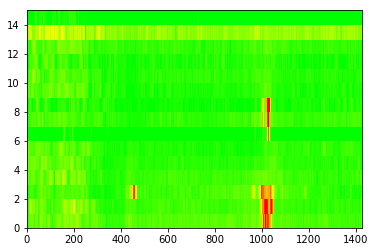

In [42]:
# plt.plot(test_speed_y[0,:,:1])  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.pcolor(test_speed_y[0,:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM

In [43]:
batch_size = train_speed_x.shape[1]

todaySequence = Input(shape=(look_back, train_speed_x1.shape[3]),name='todaySequence')
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False, return_sequences=True)(todaySequence)
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False)(h1)

historySequence = Input(shape=(look_back_days, train_speed_x2.shape[3]),name='historySequence')
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False, return_sequences=True)(historySequence)
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False)(h2)

h3 = keras.layers.concatenate([h1, h2])
predictedSpeed = Dense(train_speed_y.shape[2],name='predictedSpeed')(h3)

model = Model(inputs=[todaySequence, historySequence], outputs=[predictedSpeed])

model.compile(loss='mean_squared_error', optimizer='adam')

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})

train_x1 = np.reshape(train_speed_x1,(train_speed_x1.shape[0]*train_speed_x1.shape[1],train_speed_x1.shape[2],train_speed_x1.shape[3]))
train_x2 = np.reshape(train_speed_x2,(train_speed_x2.shape[0]*train_speed_x2.shape[1],train_speed_x2.shape[2],train_speed_x2.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))

history = model.fit({'todaySequence': train_x1, 'historySequence': train_x2},
          {'predictedSpeed': train_y},
          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# model.load_weights('images/weights/exp9.hdf5', by_name=True)
model.save_weights('images/weights/exp9.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
428925/428925 [==============================] - 110s - loss: 2960.1167   


In [48]:
history_plot_multi_historyAsSecondInput(history,'images/history_exp3.png','images/test1_exp9.png','images/test1_heatmap_exp9.png',scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_multi_historyAsSecondInput(history,'images/history_exp3.png','images/test2_exp9.png','images/test2_heatmap_exp9.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_multi_historyAsSecondInput(history,'images/history_exp3.png','images/test3_exp9.png','images/test3_heatmap_exp9.png',scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment10: input: multivariate speed; output: multivariate delta speed; lookback = 15

In [49]:
train_speed0,train_speed_y0,_,mean0,_ = get_certain_dayofweek(Speed,0,data_train)
train_speed1,train_speed_y1,_,_,_ = get_certain_dayofweek(Speed,1,data_train)
train_speed2,train_speed_y2,_,_,_ = get_certain_dayofweek(Speed,2,data_train)
train_speed3,train_speed_y3,_,_,_ = get_certain_dayofweek(Speed,3,data_train)
train_speed4,train_speed_y4,_,mean4,_ = get_certain_dayofweek(Speed,4,data_train)
train_speed5,train_speed_y5,_,_,_ = get_certain_dayofweek(Speed,5,data_train)
train_speed6,train_speed_y6,_,_,_ = get_certain_dayofweek(Speed,6,data_train)

test_speed = Speed[data_test.index,:,:]
test_speed_y0 = np.concatenate((test_speed[0:1]-mean4,test_speed[1:2]-mean0,test_speed[2:3]-mean4),axis=0)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed0.shape =  (48, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [50]:
look_back = 15
mode = 'multi'

test_speed_x,test_speed_y = create_dataset(test_speed,test_speed_y0, look_back, mode)

train_speed_x,train_speed_y = create_dataset(train_speed0,train_speed_y0, look_back, mode)
train_speed_x10,train_speed_y0 = create_dataset(train_speed1,train_speed_y1, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed2,train_speed_y2, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed3,train_speed_y3, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed4,train_speed_y4, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed5,train_speed_y5, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_y0 = create_dataset(train_speed6,train_speed_y6, look_back,mode)
train_speed_x = np.concatenate((train_speed_x,train_speed_x10),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x.shape = ',train_speed_x.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x.shape = ',test_speed_x.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

mean0=mean0[look_back:,:]
mean4=mean4[look_back:,:]

look_back =  15
look_back_days =  6
mode =  multi
train_speed_x.shape =  (343, 1425, 15, 15)
train_speed_y.shape =  (343, 1425, 15)
test_speed_x.shape =  (3, 1425, 15, 15)
test_speed_y.shape =  (3, 1425, 15)


In [57]:
# plt.plot(test_speed_y[0,:,:1]+mean4[:,:1])  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.pcolor(mean0[:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.pcolor(test_speed_y[0,:,:].transpose()+mean4[:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM

In [58]:
batch_size = train_speed_x.shape[1]

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, input_shape=(look_back, train_speed_x.shape[3]), stateful=False))
# model.add(Dropout(0.3))
model.add(Dense(train_speed_y.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')

train_x = np.reshape(train_speed_x,(train_speed_x.shape[0]*train_speed_x.shape[1],train_speed_x.shape[2],train_speed_x.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
# model.load_weights('images/weights/exp10.hdf5', by_name=True)
model.save_weights('images/weights/exp10.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
488775/488775 [==============================] - 115s - loss: 9.7542   


In [61]:
history_plot_multi(history,'images/history_exp10.png','images/test1_exp10.png','images/test1_heatmap_exp10.png',a=mean4,b=mean4,scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_multi(history,'images/history_exp10_delta.png','images/test1_exp10_delta.png','images/test1_heatmap_exp10_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=1)

history_plot_multi(history,'images/history_exp10.png','images/test2_exp10.png','images/test2_heatmap_exp10.png',a=mean0,b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_multi(history,'images/history_exp10_delta.png','images/test2_exp10_delta.png','images/test2_heatmap_exp10_delta.png',b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)

history_plot_multi(history,'images/history_exp10.png','images/test3_exp10.png','images/test3_heatmap_exp10.png',a=mean4,b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)
history_plot_multi(history,'images/history_exp10_delta.png','images/test3_exp10_delta.png','images/test3_heatmap_exp10_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)

### Experiment12: input: multivariate speed; output: multivariate delta speed; lookback = 15; lookback weeks = 6 (parallel structure)

In [62]:
train_speed0,train_speed_y0,_,mean0,_ = get_certain_dayofweek(Speed,0)
train_speed1,train_speed_y1,_,_,_ = get_certain_dayofweek(Speed,1)
train_speed2,train_speed_y2,_,_,_ = get_certain_dayofweek(Speed,2)
train_speed3,train_speed_y3,_,_,_ = get_certain_dayofweek(Speed,3)
train_speed4,train_speed_y4,_,mean4,_ = get_certain_dayofweek(Speed,4)
train_speed5,train_speed_y5,_,_,_ = get_certain_dayofweek(Speed,5)
train_speed6,train_speed_y6,_,_,_ = get_certain_dayofweek(Speed,6)

test_speed = Speed[data_test.index,:,:]
test_speed_y0 = np.concatenate((test_speed[0:1]-mean4,test_speed[1:2]-mean0,test_speed[2:3]-mean4),axis=0)

print('train_speed0.shape = ',train_speed0.shape)
print('test_speed.shape = ',test_speed.shape)

train_speed0.shape =  (49, 1440, 15)
test_speed.shape =  (3, 1440, 15)


In [63]:
index1=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][0])
index2=list(data.index[data['dayofweek'] == 0]).index(data_test.index[data_test['dayofweek'] == 0][0])
index3=list(data.index[data['dayofweek'] == 4]).index(data_test.index[data_test['dayofweek'] == 4][1])
print('index1={}  index2={}  index3={} '.format(index1,index2,index3))

index1=45  index2=45  index3=47 


In [64]:
look_back = 15
look_back_days = 6
mode = 'multi'
train_speed_x1,train_speed_x2,train_speed_y = create_dataset_historyAsSecondInput(train_speed0,train_speed_y0, look_back, look_back_days, mode)
test_speed_x1_2 = train_speed_x1[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_x2_2 = train_speed_x2[index2-look_back_days:index1-look_back_days+1,:,:,:]
test_speed_y_2 = train_speed_y[index2-look_back_days:index1-look_back_days+1,:,:]
train_speed_x1 = train_speed_x1[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x1))),:,:,:]
train_speed_x2 = train_speed_x2[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_x2))),:,:,:]
train_speed_y = train_speed_y[list(range(index2-look_back_days))+list(range(index2-look_back_days+1,len(train_speed_y))),:,:]

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed1,train_speed_y1, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed2,train_speed_y2, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed3,train_speed_y3, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed4,train_speed_y4, look_back, look_back_days, mode)
test_speed_x1_13 = train_speed_x10[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_x2_13 = train_speed_x20[[index1-look_back_days,index3-look_back_days],:,:,:]
test_speed_y_13 = train_speed_y0[[index1-look_back_days,index3-look_back_days],:,:]
train_speed_x10 = train_speed_x10[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x10))),:,:,:]
train_speed_x20 = train_speed_x20[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_x20))),:,:,:]
train_speed_y0 = train_speed_y0[list(range(index1-look_back_days))+list(range(index1-look_back_days+1,index3-look_back_days))+list(range(index3-look_back_days+1,len(train_speed_y0))),:,:]

train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed5,train_speed_y5, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)
train_speed_x10,train_speed_x20,train_speed_y0 = create_dataset_historyAsSecondInput(train_speed6,train_speed_y6, look_back, look_back_days, mode)
train_speed_x1 = np.concatenate((train_speed_x1,train_speed_x10),axis=0)
train_speed_x2 = np.concatenate((train_speed_x2,train_speed_x20),axis=0)
train_speed_y = np.concatenate((train_speed_y,train_speed_y0),axis=0)

test_speed_x1 = np.concatenate((test_speed_x1_13[0:1],test_speed_x1_2,test_speed_x1_13[-1:]),axis=0)
test_speed_x2 = np.concatenate((test_speed_x2_13[0:1],test_speed_x2_2,test_speed_x2_13[-1:]),axis=0)                                                                          
test_speed_y = np.concatenate((test_speed_y_13[0:1],test_speed_y_2,test_speed_y_13[-1:]),axis=0)  
                                                                        
print('look_back = ',look_back)
print('look_back_days = ',look_back_days)
print('mode = ',mode)
print('train_speed_x1.shape = ',train_speed_x1.shape)
print('train_speed_x2.shape = ',train_speed_x2.shape)
print('train_speed_y.shape = ',train_speed_y.shape)
print('test_speed_x1.shape = ',test_speed_x1.shape)
print('test_speed_x2.shape = ',test_speed_x2.shape)
print('test_speed_y.shape = ',test_speed_y.shape)

mean0=mean0[look_back:,:]
mean4=mean4[look_back:,:]

look_back =  15
look_back_days =  6
mode =  multi
train_speed_x1.shape =  (301, 1425, 15, 15)
train_speed_x2.shape =  (301, 1425, 6, 15)
train_speed_y.shape =  (301, 1425, 15)
test_speed_x1.shape =  (3, 1425, 15, 15)
test_speed_x2.shape =  (3, 1425, 6, 15)
test_speed_y.shape =  (3, 1425, 15)


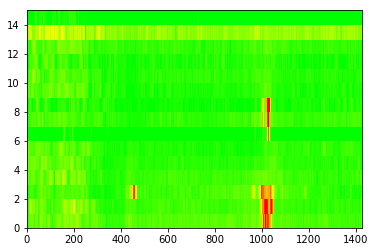

In [68]:
# plt.plot(test_speed_y[0,:,:1]+mean4[:,:1])  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.pcolor(mean0[:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM
# plt.pcolor(test_speed_y[0,:,:].transpose()+mean4[:,:].transpose(),cmap=my_cmap, vmin=20, vmax=70)  #12-19-2016 Monday 6:30AM - 8:30AM

In [69]:

batch_size = train_speed_x.shape[1]

todaySequence = Input(shape=(look_back, train_speed_x1.shape[3]),name='todaySequence')
h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False, return_sequences=True)(todaySequence)

h1=LSTM(32, input_shape=(look_back, train_speed_x1.shape[3]), stateful=False,name='h1')(todaySequence)

historySequence = Input(shape=(look_back_days, train_speed_x2.shape[3]),name='historySequence')
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False, return_sequences=True)(historySequence)
h2=LSTM(32, input_shape=(look_back, train_speed_x2.shape[3]), stateful=False,name='h2')(h2)

h3 = keras.layers.concatenate([h1, h2],name='h3')
# h3 = keras.layers.concatenate([h1, h2],name='h3')

predictedSpeed = Dense(train_speed_y.shape[2],name='predictedSpeed')(h3)

model = Model(inputs=[todaySequence, historySequence], outputs=[predictedSpeed])

model.compile(loss='mean_squared_error', optimizer='adam')

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})

train_x1 = np.reshape(train_speed_x1,(train_speed_x1.shape[0]*train_speed_x1.shape[1],train_speed_x1.shape[2],train_speed_x1.shape[3]))
train_x2 = np.reshape(train_speed_x2,(train_speed_x2.shape[0]*train_speed_x2.shape[1],train_speed_x2.shape[2],train_speed_x2.shape[3]))
train_y = np.reshape(train_speed_y,(train_speed_y.shape[0]*train_speed_y.shape[1],train_speed_y.shape[2]))

history = model.fit({'todaySequence': train_x1, 'historySequence': train_x2},
          {'predictedSpeed': train_y},
          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# model.load_weights('images/weights/exp12.hdf5', by_name=True)
model.save_weights('images/weights/exp12.hdf5')

/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/1
428925/428925 [==============================] - 64s - loss: 9.5245    


In [ ]:
history_plot_multi_historyAsSecondInput(history,'images/history_exp12.png','images/test1_exp12.png','images/test1_heatmap_exp12.png',a=mean4,b=mean4,scoreflag=True,look_ahead = 1400,start = 0,test_case=1)
history_plot_multi_historyAsSecondInput(history,'images/history_exp12_delta.png','images/test1_exp12_delta.png','images/test1_heatmap_exp12_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=1)

history_plot_multi_historyAsSecondInput(history,'images/history_exp12.png','images/test2_exp12.png','images/test2_heatmap_exp12.png',a=mean0,b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)
history_plot_multi_historyAsSecondInput(history,'images/history_exp12_delta.png','images/test2_exp12_delta.png','images/test2_heatmap_exp12_delta.png',b=mean0,scoreflag=False,look_ahead = 1400,start = 0,test_case=2)

history_plot_multi_historyAsSecondInput(history,'images/history_exp12.png','images/test3_exp12.png','images/test3_heatmap_exp12.png',a=mean4,b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)
history_plot_multi_historyAsSecondInput(history,'images/history_exp12_delta.png','images/test3_exp12_delta.png','images/test3_heatmap_exp12_delta.png',b=mean4,scoreflag=False,look_ahead = 1400,start = 0,test_case=3)